#Importing data & libraies


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('/content/adult.data.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#Data Vis

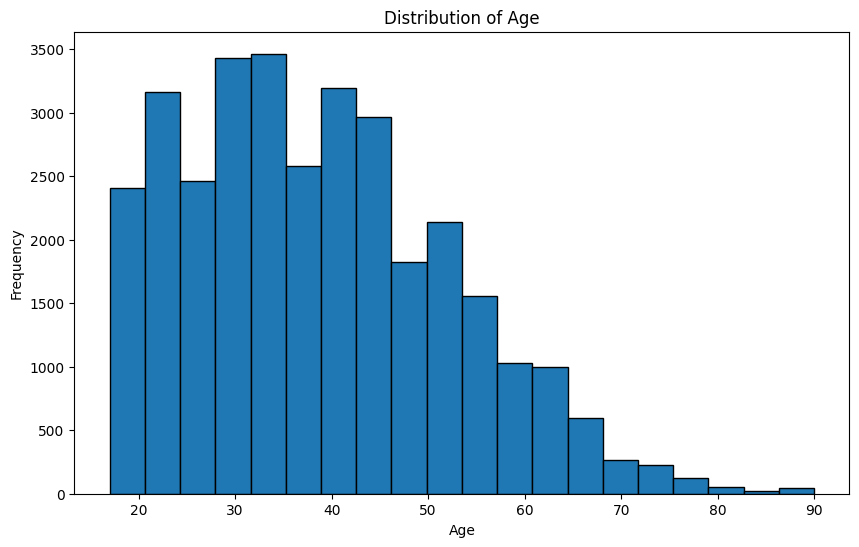

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()


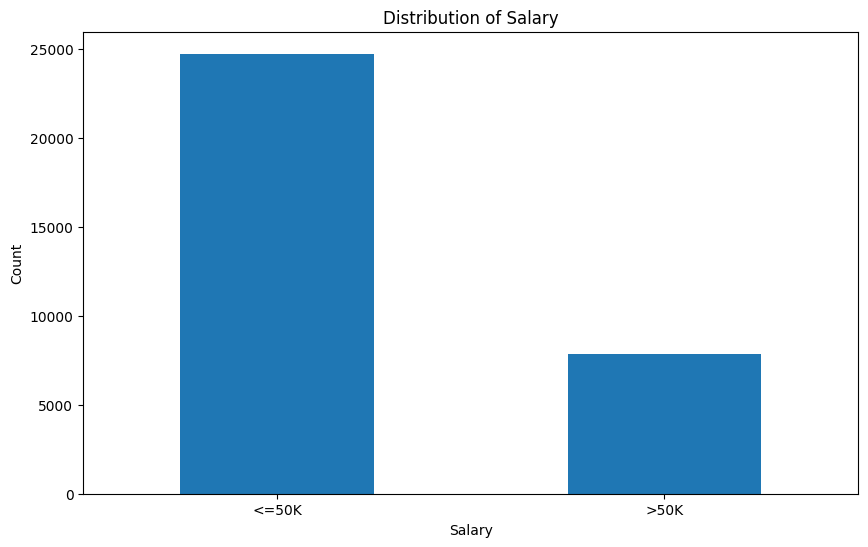

In [6]:
plt.figure(figsize=(10, 6))
df['salary'].value_counts().plot(kind='bar')
plt.xlabel('Salary')
plt.ylabel('Count')
plt.title('Distribution of Salary')
plt.xticks(rotation=0)
plt.show()

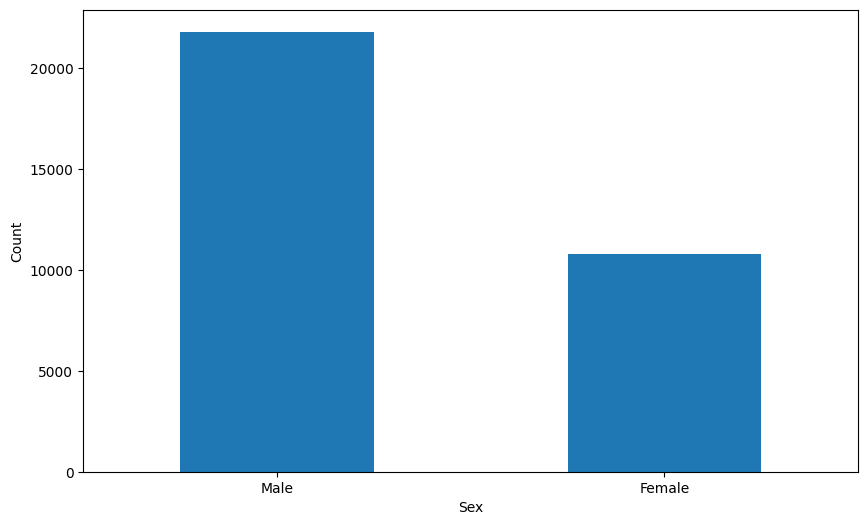

In [10]:
plt.figure(figsize=(10,6))
df['sex'].value_counts().plot(kind='bar')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


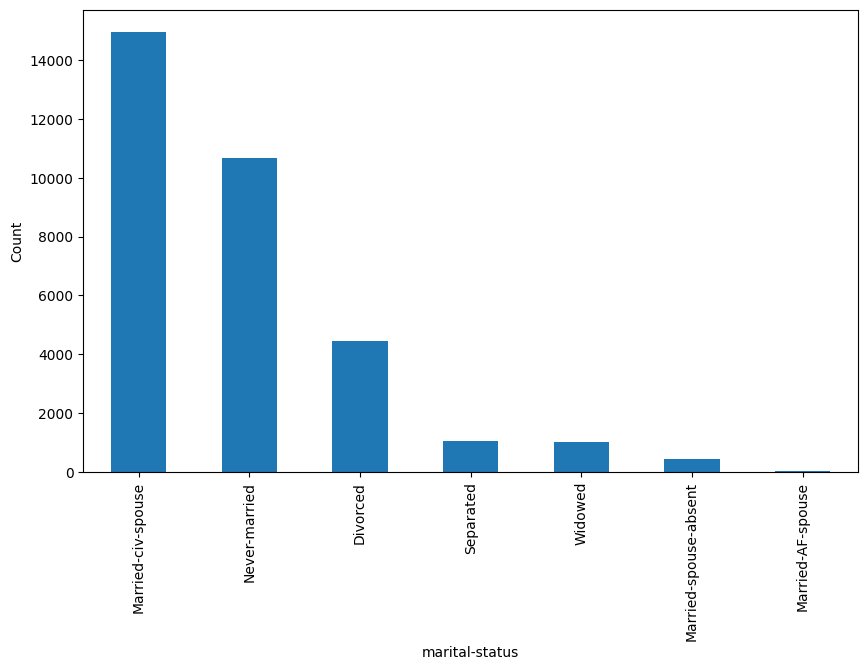

In [11]:
plt.figure(figsize=(10,6))
df['marital-status'].value_counts().plot(kind='bar')
plt.xlabel('marital-status')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

#Model

In [16]:
X=df.drop(columns=['salary'])
y=df['salary']

In [19]:
num_feat=X.select_dtypes(include=['number']).columns.tolist()
cat_feat=X.select_dtypes(include=['bool','object','category']).columns.tolist()

In [26]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

In [27]:
num_pipe=Pipeline([('imputer',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([('num', num_pipe, num_feat),
                                  ('cat', cat_pipe, cat_feat)])

In [28]:
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# 5) train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6) CV + grid search (adapt grid to save time)
n_classes = len(np.unique(y_train))
scoring = 'roc_auc' if n_classes == 2 else 'roc_auc_ovr'

In [30]:
param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [None, 10],
    'clf__min_samples_leaf': [1, 3]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best = grid.best_estimator_
print("Best params:", grid.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 300}


In [31]:
y_pred = best.predict(X_test)
if n_classes == 2:
    y_proba = best.predict_proba(X_test)[:, 1]
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
else:
    y_proba = best.predict_proba(X_test)
    print("ROC AUC (ovr):", roc_auc_score(y_test, y_proba, multi_class='ovr'))

print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


ROC AUC: 0.9155278858257154
              precision    recall  f1-score   support

       <=50K       0.93      0.84      0.89      4945
        >50K       0.62      0.81      0.71      1568

    accuracy                           0.84      6513
   macro avg       0.78      0.83      0.80      6513
weighted avg       0.86      0.84      0.84      6513

Confusion matrix:
 [[4178  767]
 [ 294 1274]]


In [33]:
clf = best.named_steps['clf']
if hasattr(clf, 'feature_importances_'):
    ohe = best.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(cat_feat) if hasattr(ohe, "get_feature_names_out") else ohe.get_feature_names(cat_feat)
    feature_names = num_feat + list(cat_names)
    importances = clf.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print(fi.head(20))

marital-status_Married-civ-spouse    0.118900
age                                  0.103886
relationship_Husband                 0.088019
education-num                        0.081547
hours-per-week                       0.071009
marital-status_Never-married         0.062609
capital-gain                         0.059773
fnlwgt                               0.029012
relationship_Not-in-family           0.025153
occupation_Exec-managerial           0.024760
relationship_Own-child               0.024271
sex_Male                             0.023476
relationship_Wife                    0.022735
occupation_Prof-specialty            0.021107
sex_Female                           0.016896
occupation_Other-service             0.016489
education_Bachelors                  0.015644
marital-status_Divorced              0.013738
capital-loss                         0.013647
education_HS-grad                    0.012350
dtype: float64


/tmp/ipython-input-2731148406.py:35: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


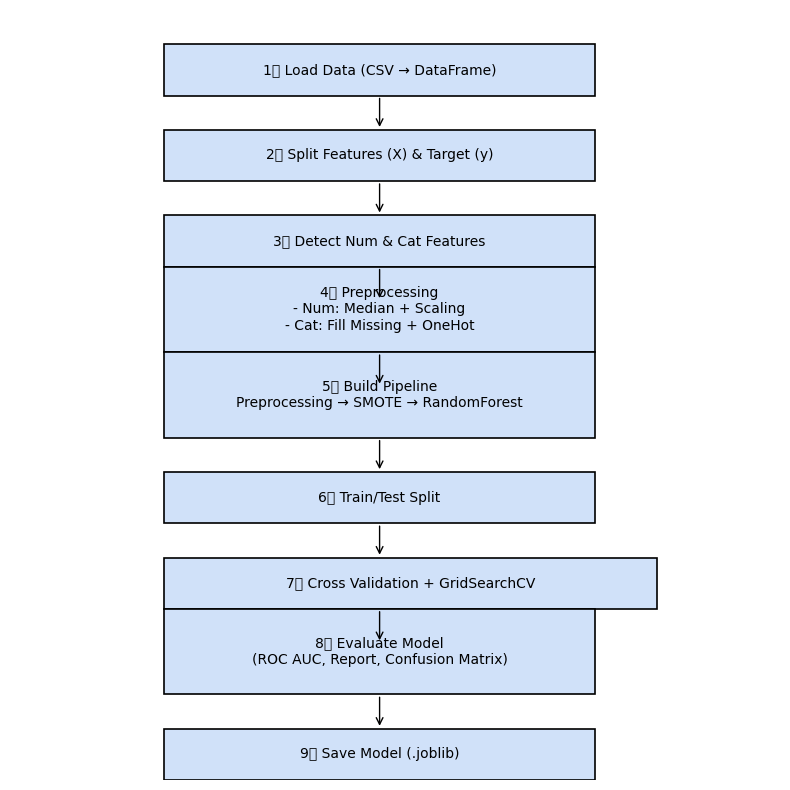

In [34]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# Helper function to draw boxes with arrows
def draw_box(ax, text, xy, width=2.8, height=0.6, fontsize=10):
    box = plt.Rectangle((xy[0], xy[1]), width, height, fill=True, color="#d0e1f9", ec="black", lw=1.2)
    ax.add_patch(box)
    ax.text(xy[0] + width/2, xy[1] + height/2, text, ha='center', va='center', fontsize=fontsize, wrap=True)

def draw_arrow(ax, start, end):
    arrow = FancyArrowPatch(posA=start, posB=end, arrowstyle='->', mutation_scale=12, linewidth=1)
    ax.add_patch(arrow)

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, 5)
ax.set_ylim(0, 9)
ax.axis('off')

# Draw boxes
draw_box(ax, "1️⃣ Load Data (CSV → DataFrame)", (1, 8))
draw_box(ax, "2️⃣ Split Features (X) & Target (y)", (1, 7))
draw_box(ax, "3️⃣ Detect Num & Cat Features", (1, 6))
draw_box(ax, "4️⃣ Preprocessing\n- Num: Median + Scaling\n- Cat: Fill Missing + OneHot", (1, 5), height=1)
draw_box(ax, "5️⃣ Build Pipeline\nPreprocessing → SMOTE → RandomForest", (1, 4), height=1)
draw_box(ax, "6️⃣ Train/Test Split", (1, 3))
draw_box(ax, "7️⃣ Cross Validation + GridSearchCV", (1, 2), width=3.2)
draw_box(ax, "8️⃣ Evaluate Model\n(ROC AUC, Report, Confusion Matrix)", (1, 1), height=1)
draw_box(ax, "9️⃣ Save Model (.joblib)", (1, 0))

# Draw arrows
for y in range(8, 0, -1):
    draw_arrow(ax, (2.4, y), (2.4, y-0.4))

plt.tight_layout()
plt.show()
